
# Visual Saliency Part 3: Scanpath Prediction

## <a href="https://yuejiang-nj.github.io/">Yue Jiang</a> / Aalto University

This notebook provides a brief introduction to scanpath prediction techniques. 

#### Primary sources
1. DeepGaze III: Modeling free-viewing human scanpaths with deep learning. Journal of Vision 2022 [Paper](https://jov.arvojournals.org/article.aspx?articleid=2778776) [Github](https://github.com/matthias-k/DeepGaze).


## Examples of ground truth scanpaths

<div>
<img src="imgs/scanpath.png" style="" width=100%>
</div>

## Scanpath Predictive Model --- DeepGaze III

---

## 1. Model overview
**DeepGaze III** is a deep learning–based model that combines image information with information about the previous fixation history to predict where a participant might fixate next.




## 2. Preparations

### Step 1. Installing conda and importing packages

In [1]:
!python setup.py install

running install
/opt/software/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/opt/software/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See

In [2]:
!pip install torch scipy imageio opencv-python matplotlib

In [10]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch
import glob
import sys
import deepgaze_pytorch
import os
import cv2

### Step 2. Define auxiliary functions

In [4]:
# the fixations parameters indicates the number of previous fixations to take into account
# to compute the probability of the next fixations
# it is set to 1 at the first recursive step
def prediction(image, fixations_x, fixations_y, centerbias, fixations, mask):

    # location of previous scanpath fixations in x and y (pixel coordinates), starting with the initial fixation on the image.
    fixation_history_x = np.array(fixations_x)
    fixation_history_y = np.array(fixations_y)

    model = deepgaze_pytorch.DeepGazeIII(fixations, pretrained=True)

    image_tensor = torch.tensor([image.transpose(2, 0, 1)])
    centerbias_tensor = torch.tensor([centerbias])
    x_hist_tensor = torch.tensor([fixation_history_x[model.included_fixations]])
    y_hist_tensor = torch.tensor([fixation_history_x[model.included_fixations]])

    log_density_prediction = (100 + model(image_tensor, centerbias_tensor, x_hist_tensor, y_hist_tensor)) \
                                * mask.unsqueeze(0).unsqueeze(0)

    # Find the brightest pixel in the probaility map
    brightest_pixel = (log_density_prediction==torch.max(log_density_prediction)).nonzero()[0].detach().cpu().numpy()

    return brightest_pixel

### Step 3: Inhibition of Return

Repeatedly applies the ''inhibition of return'' feedback to inhibit the chosen position in the saliency map to get the resulting scanpaths.

<div>
<img src="imgs/ior.png" style="" width=100%>
</div>

In [5]:
def create_circular_mask(h, w, fixations_x, fixations_y, radius):

    # get the circular mask
    mask = torch.ones(h, w)
    ####### TODO: implement circular mask #######
    # You need to comment the above line
    # Hint: fixations_x is a list containing the x-values of all the previous points
    #       fixations_y containts the corresponding y-values
    #       you need to create a mask with the same size as the input image (w, h)
    #       the circles around all previous points are black and other areas are all white.

    
    return mask


### Step 4: Load images

In [12]:
# Update this line to include the files you want to test: 
#### you can remove some in the list to test efficiently
img_paths = ['./inputs/windows11.jpg', './inputs/reddit.jpg', './inputs/cluttered.jpg'] # './inputs/windows11.jpg' './inputs/iphone.jpg'

### Step 5: Predict Scanpaths

In [13]:
# define the number of points in the predicted scanpaths
#### you can make the number smaller to test efficiently
num_scanpath_points = 3

./inputs/windows11.jpg


/tmp/ipykernel_307/2033649019.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(path)
Using cache found in /home/langert1/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/langert1/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/langert1/.cache/torch/hub/pytorch_vision_v0.6.0


plot
./inputs/reddit.jpg


Using cache found in /home/langert1/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/langert1/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/langert1/.cache/torch/hub/pytorch_vision_v0.6.0


plot
./inputs/cluttered.jpg


Using cache found in /home/langert1/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/langert1/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/langert1/.cache/torch/hub/pytorch_vision_v0.6.0


plot


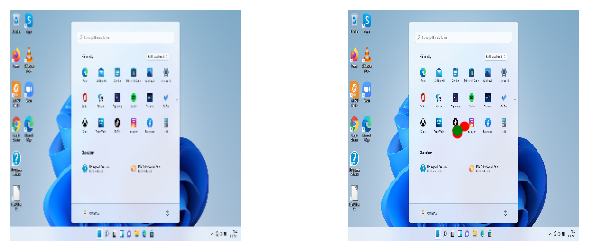

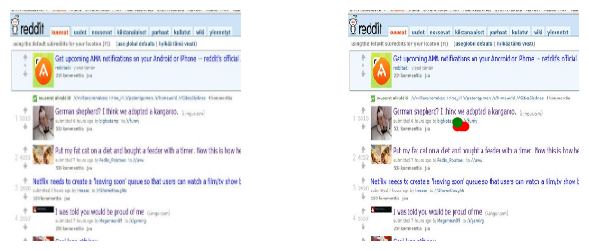

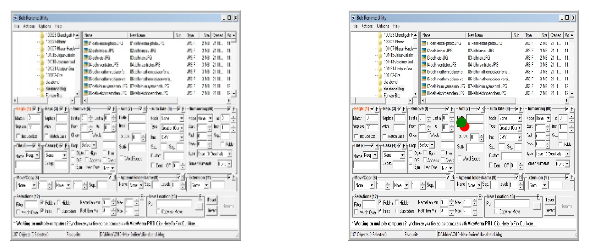

In [14]:
# This block may take some time to run (maybe 5 mins)
for path in img_paths:
    print(path)
    image = imread(path)
    image = cv2.resize(image, (256, 256))
    image_file_name = path.split("/")[-1].split(".")[0]

    # load precomputed centerbias log density (from MIT1003) over a 400x1024 image
    # you can download the centerbias from https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/centerbias_mit1003.npy
    # alternatively, you can use a uniform centerbias via `centerbias_template = np.zeros((1024, 1024))`.
    centerbias_template = np.load('assets/centerbias_mit1003.npy')
    
    # rescale to match image size
    centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
    
    # renormalize log density
    centerbias -= logsumexp(centerbias)

    # Fixation history set as the center of the image
    height = image.shape[0] // 2
    width = image.shape[1] // 2

    # Result scanpath
    fixations_x = [width]
    fixations_y = [height]
    fixations = 1

    # Recursively predict the fixations until we have predicted 13 of them
    while len(fixations_x) <= num_scanpath_points:

        # Inhibition of Return (IOB)
        radius = int(0.2 * min(image.shape[1], image.shape[0]))
        mask = create_circular_mask(image.shape[0], image.shape[1], fixations_x, fixations_y, radius)
        brightest_pixel = prediction(image * mask.unsqueeze(2).numpy().astype('uint8'), fixations_x, fixations_y, centerbias, fixations, mask)

        # add the newly predicted pixel to the history of fixations
        fixations_x.append(brightest_pixel[3])
        fixations_y.append(brightest_pixel[2])

        # For each new fixation point we increase the fixations parameter by 1 until it hits 4
        if fixations <= 3:
            fixations += 1

    # Plot and save the result as a png file
    print("plot")
    f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    axs[0].imshow(image)
    axs[0].set_axis_off()

    axs[1].matshow(image)  # first image in batch, first (and only) channel
    axs[1].plot(fixations_x, fixations_y, 'o-', color='red')
    axs[1].scatter(fixations_x[-1], fixations_y[-1], 40, color='green', zorder=100)
    axs[1].set_axis_off()
    
    os.makedirs("outputs", exist_ok=True)
    
    plt.savefig("outputs/{}.png".format(image_file_name), transparent=True)


### If you get approximately the following results, your answers are correct! Yay!!! :-)
<div>
<img src="imgs/scanpath_results.png" style="" width=50%>
</div>